In [118]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy #For deepcopy
import miceforest
from miceforest import ImputationKernel #Multivariate imputation technique for missing values

from matplotlib import rcParams

from sklearn.preprocessing import StandardScaler

from scipy import stats
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns 
from sklearn import svm

In [119]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Overview

## Basic

In [120]:
print('-- Shape --  \ntrain : ', train.shape, '\ntest: ', test.shape)
print('-- Head --\n', train.head())

print('HomePlanet', train['HomePlanet'].unique())
print('CryoSleep', train['CryoSleep'].unique())
print('Destination', train['Destination'].unique())
print('VIP', train['VIP'].unique())

-- Shape --  
train :  (8693, 14) 
test:  (4277, 13)
-- Head --
   PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1    

In [121]:
#Print column names, types and nulls
for elm in train:
    print(elm, ':', train[elm].dtypes, train[elm].isnull().sum())

PassengerId : object 0
HomePlanet : object 201
CryoSleep : object 217
Cabin : object 199
Destination : object 182
Age : float64 179
VIP : object 203
RoomService : float64 181
FoodCourt : float64 183
ShoppingMall : float64 208
Spa : float64 183
VRDeck : float64 188
Name : object 200
Transported : bool 0


## Plots

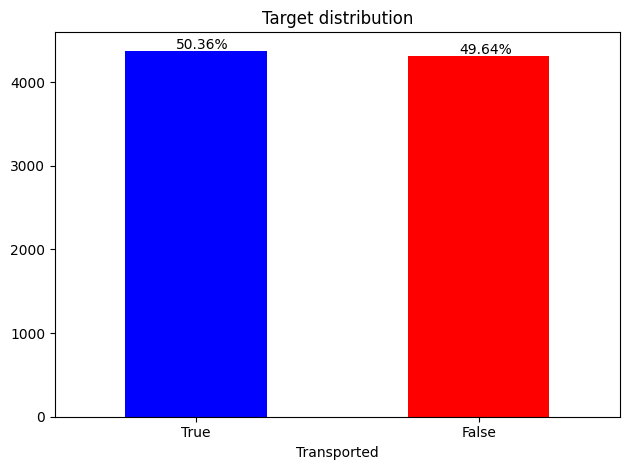

In [122]:
# Get labels
labels = np.array(train['Transported'].value_counts())
labels = (labels / labels.sum(axis=0) * 100).round(decimals=2).astype(str)
labels = list(map(lambda x : x+'%', labels))

# Plot
train['Transported'].value_counts().plot(kind='bar', color=('blue', 'red'))
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 0)
# ax.bar_label(ax.containers[0], label_type='edge')
i = 0
for p in ax.patches:
    ax.annotate(str(labels[i]), (p.get_x() + 0.18, p.get_height() * 1.005))
    i =+ 1
plt.title('Target distribution')
plt.show()

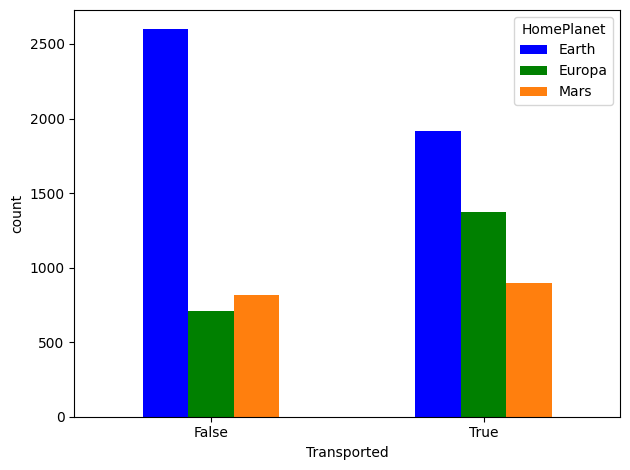

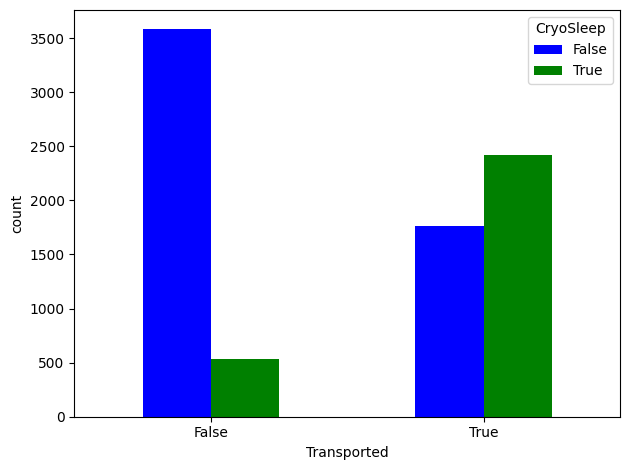

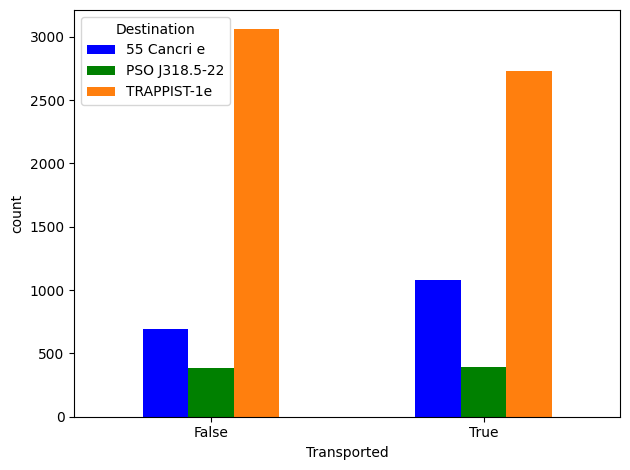

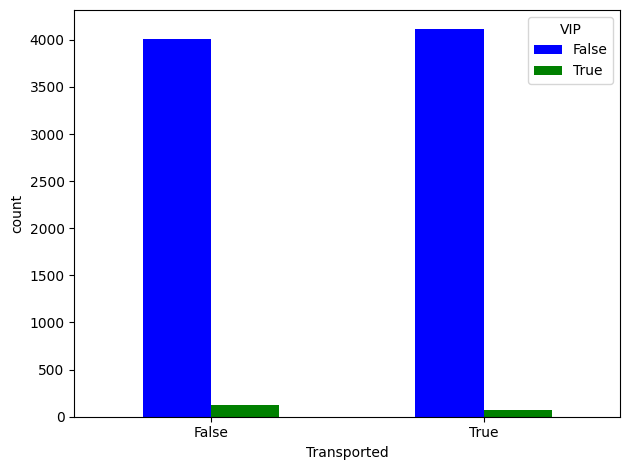

In [128]:
lst = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
for elm in lst:
    df_pivot = pd.pivot_table(
        train[["Age", "Transported", elm]],
        index="Transported",
        columns=elm,
        values=elm,
        aggfunc='count')

    fig, ax = plt.subplots()
    df_pivot.plot(kind="bar", ax=ax, color=['blue', 'green', 'tab:orange'])
    ax.tick_params(axis='x', rotation=0)
    ax.set_ylabel("count")
    plt.show()

## Correlation

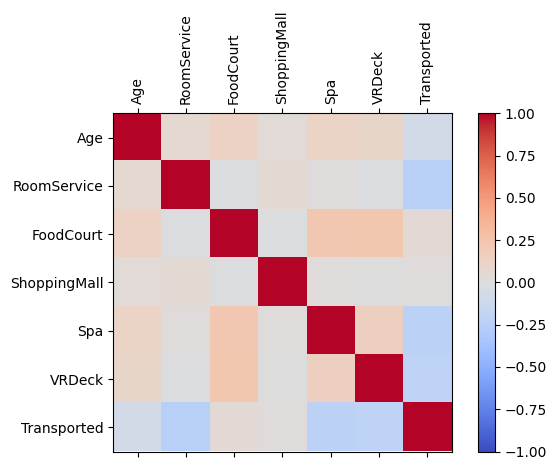

In [90]:
# Heatmap of correlation with numerical variables
df_num = train.select_dtypes(include = ['float64', 'int64', 'bool'])

corr = df_num.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_num.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_num.columns)
ax.set_yticklabels(df_num.columns)
plt.show()

In [91]:
train_ = copy.deepcopy(train)
train_ = train_.dropna()

In [92]:
corr_list = []
y = train_['Transported']

for col in df_num:
    if col == 'Transported': continue
    x=train_[col]
    corr = stats.pointbiserialr(list(x), list(y))
    corr_list.append((col, corr[0]))
print('Biserial correlation between feature and target')
print(corr_list)

Biserial correlation between feature and target
[('Age', -0.08255287690970185), ('RoomService', -0.24729078183708378), ('FoodCourt', 0.05502465048064445), ('ShoppingMall', 0.011601728883922267), ('Spa', -0.2198542639203347), ('VRDeck', -0.20794964666038265)]


# Preprocessing

### Missing values

In [93]:
def removeNull(df):
    #Remove rows with categorial na's
    for elm in train:
        if elm not in df_num:
            df = df.dropna(subset=[elm])

    # Multivariate imputation for numerical values (Works for categorial as well)
    mice_kernel = ImputationKernel(
        data = df_num,
        save_all_iterations = True,
        random_state = 2023)
    mice_kernel.mice(2)
    df_ = mice_kernel.complete_data()
    for elm in df_: df[elm] = df_[elm]
    return df

train = removeNull(train)

In [94]:
print('null count == ', train.loc[:, train.columns != "Name"].isna().sum().sum())
print(train.head())

null count ==  0
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4 

### Feature engineering

Group = gggg of PassengerId <br>
Number = pp of PassengerId <br>
Split cabin into: deck, side and section 0-500 : A, 501-1000 : B, 1001 - 1500 : C, 1500+ D <br>
Age = Age group <br>
RoomService, FoodCourt, ShoppingMall, Spa, VRDeck = Spendings 

In [95]:
def feaEng(df):
    # df['Group'] = df['PassengerId'].str.split("_").map(lambda x: x[0])
    df['Number'] = df['PassengerId'].str.split("_").map(lambda x: x[1])
    df['Deck'] = df['Cabin'].str.split("/").map(lambda x: x[0])
    df['Side'] = df['Cabin'].str.split("/").map(lambda x: x[2])
    
    #Section is the room number, this is converted into categoriacal values.
    df['Section'] = df['Cabin'].str.split("/").map(lambda x: x[1])
    df['Section'] = df['Section'].astype('int32')
    names = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    bins = [0, 250, 500, 750, 1000, 1250, 1500]
    d = dict(enumerate(names, 1))
    df['Section'] = np.vectorize(d.get)(np.digitize(df['Section'], bins))
    
    #Age is converted into categoriacal values.
    df['Age'] = pd.cut(df['Age'],bins=[0,2,17, 35,65,99],labels=['Toddler','Child','Young adult','Adult','Elderly'])
    df['Spendings'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
    
    #Drop columns
    df = df.drop(columns=['Name', 'Cabin'])
    return df
train = feaEng(train)
print(train.head())


  PassengerId HomePlanet CryoSleep  Destination          Age    VIP  \
0     0001_01     Europa     False  TRAPPIST-1e        Adult  False   
1     0002_01      Earth     False  TRAPPIST-1e  Young adult  False   
2     0003_01     Europa     False  TRAPPIST-1e        Adult   True   
3     0003_02     Europa     False  TRAPPIST-1e  Young adult  False   
4     0004_01      Earth     False  TRAPPIST-1e        Child  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  Transported Number  \
0          0.0        0.0           0.0     0.0     0.0        False     01   
1        109.0        9.0          25.0   549.0    44.0         True     01   
2         43.0     3576.0           0.0  6715.0    49.0        False     01   
3          0.0     1283.0         371.0  3329.0   193.0        False     02   
4        303.0       70.0         151.0   565.0     2.0         True     01   

  Deck Side Section  Spendings  
0    B    P       A        0.0  
1    F    S       A      736.0  

# Overview 2

In [96]:
rcParams.update({'figure.autolayout': True})
df_obj = train.select_dtypes(include = ['object'])
df_obj = df_obj.drop(columns=['PassengerId'])

def autoSavePlt():
    for i in df_obj:
        ax = df_obj[i].value_counts().plot(kind='bar', grid=True)
        ax.figure.savefig('plots/' + i + 'Overview2.png')

0           0.0
1         736.0
2       10383.0
3        5176.0
4        1091.0
         ...   
8688     8536.0
8689        0.0
8690     1873.0
8691     4637.0
8692     4826.0
Name: Spendings, Length: 7559, dtype: float64


<Axes: >

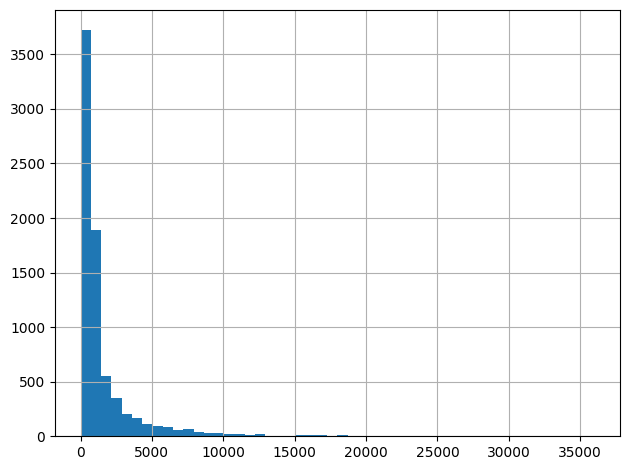

In [97]:
print(train['Spendings'])
train['Spendings'].hist(bins=50)

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'RoomService'}>,
        <Axes: title={'center': 'FoodCourt'}>],
       [<Axes: title={'center': 'ShoppingMall'}>,
        <Axes: title={'center': 'Spa'}>,
        <Axes: title={'center': 'VRDeck'}>]], dtype=object)

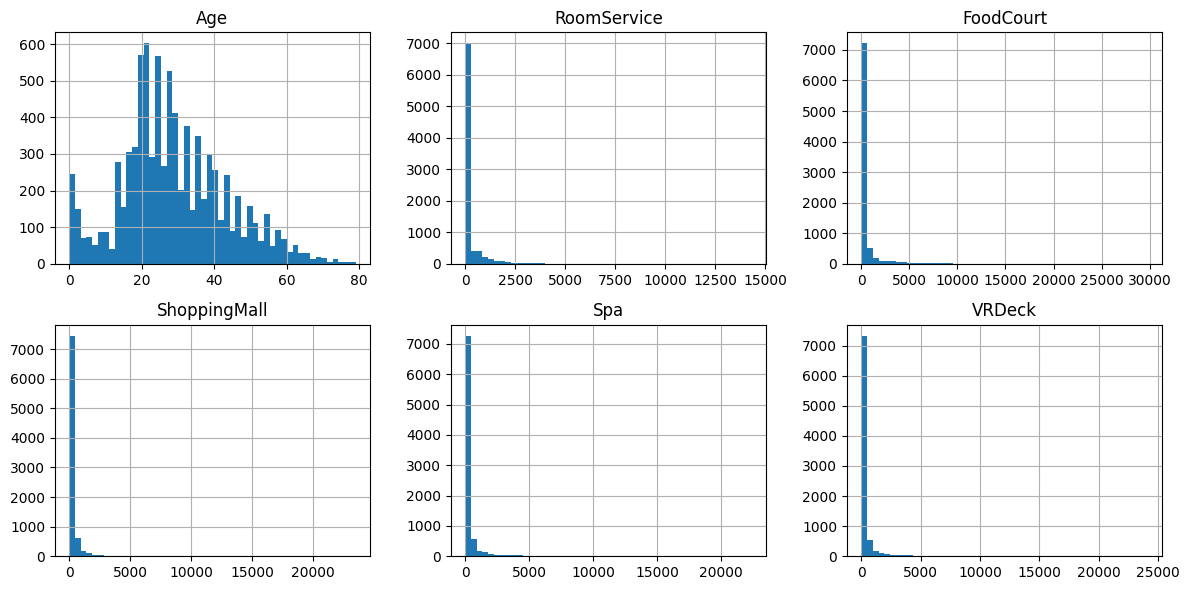

In [145]:
train.select_dtypes(include = ['float64', 'int64']).hist(figsize=(12, 6), bins=50, layout=(2,3))

 --- Nul percentage for Spa --- 
True : 77.73%
False: 44.52%


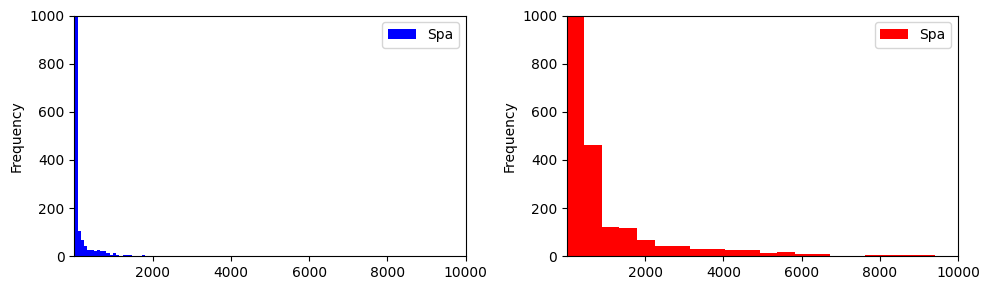

 --- Nul percentage for Spa --- 
True : 77.73%
False: 44.52%


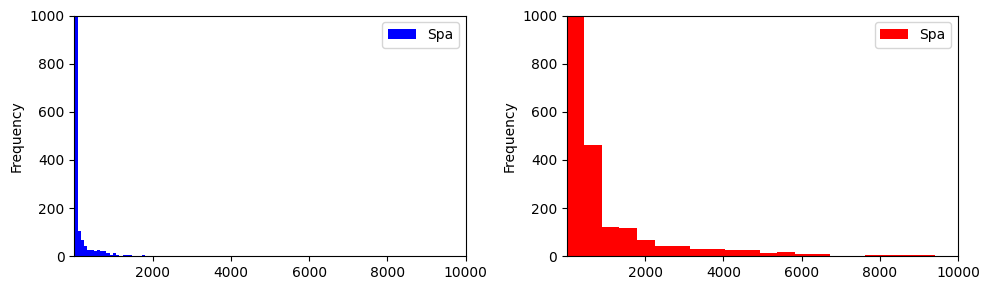

 --- Nul percentage for Spa --- 
True : 77.73%
False: 44.52%


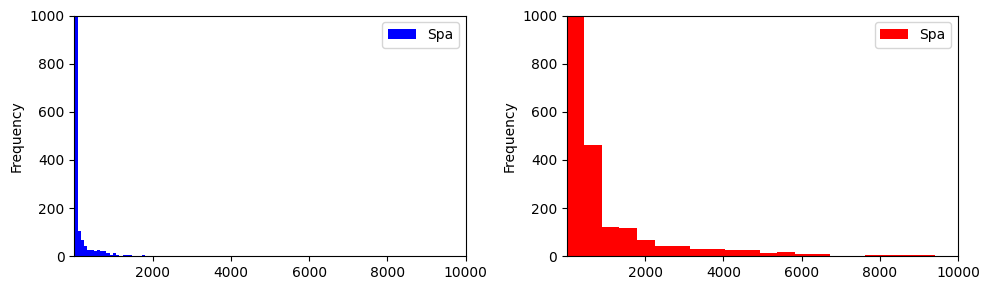

 --- Nul percentage for Spa --- 
True : 77.73%
False: 44.52%


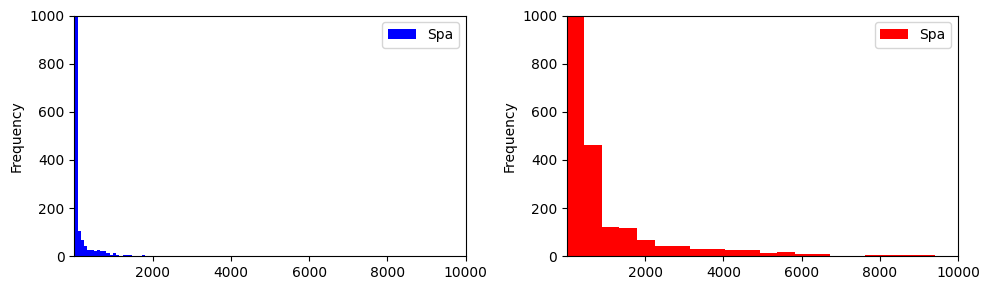

 --- Nul percentage for Spa --- 
True : 77.73%
False: 44.52%


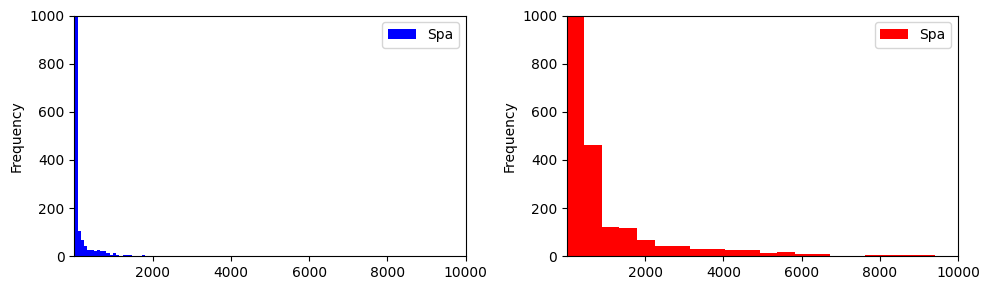

 --- Nul percentage for Spa --- 
True : 77.73%
False: 44.52%


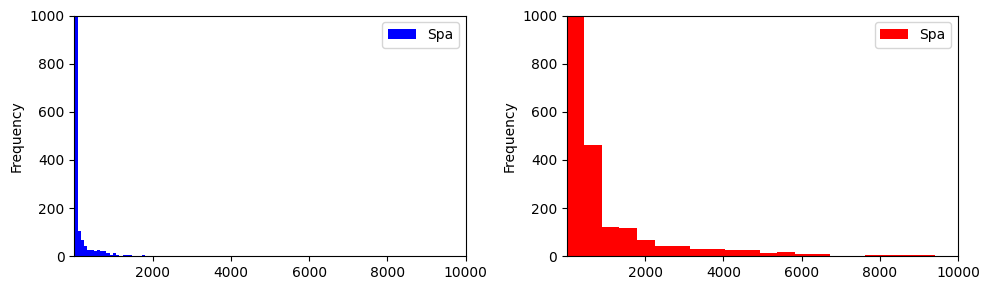

In [211]:
def getPerc(df, i):
    count = df[i].value_counts()[0]
    len = df.shape[0]
    return round((count / len) * 100, 2)

for elm in train.select_dtypes(include = ['float64', 'int64']):
    df_ = train[['Transported', 'Spa']]
    df_true = df_[df_['Transported'] == True]
    df_false = df_[df_['Transported'] == False]
    percTrue = getPerc(df_true, 'Spa')
    percFalse = getPerc(df_false, 'Spa')
    print(" --- Nul percentage for {} --- ".format('Spa'))
    print('True : ' + str(percTrue) + '%')
    print('False: ' + str(percFalse) + '%')


    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,3))
    df_true.plot(kind="hist", ax=ax1, bins=50, ylim=[0,1000], xlim=[1,10000], color='blue')
    df_false.plot(kind="hist", ax=ax2, bins=50, ylim=[0,1000], xlim=[1,10000], color='red')
    ax.tick_params(axis='x', rotation=0)
    ax.set_ylabel("count")
    plt.show()

# Preproccesing 2

In [99]:
train = train.drop(columns=['PassengerId'])

In [100]:
# Convert categorial variables into binary dummy variables
def dummy(df):
    df = pd.get_dummies(df)
    return df
train = dummy(train)

In [101]:
def logTransform(df):
    df['Spendings'] = np.log1p(df['Spendings'])
    return df
train = logTransform(train)

<Axes: >

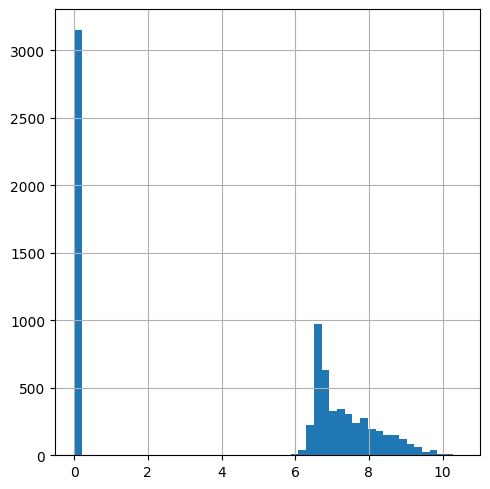

In [102]:
train['Spendings'].hist(figsize=(5, 5), bins=50)

In [103]:
def scale(df):
    scaler = StandardScaler()
    df = scaler.fit_transform(df)
    return df

# Models

In [104]:
Xtrain, foo = train_test_split(train, test_size=0.2, shuffle=True, random_state = 42)
Xtest, Xval = train_test_split(foo, test_size=0.5, shuffle=True, random_state = 42)

Ytrain, Ytest, Yval = Xtrain.pop('Transported').astype(int), Xtest.pop('Transported').astype(int), Xval.pop('Transported').astype(int)
Xtrain, Xtest, Xval = scale(Xtrain), scale(Xtest), scale(Xval)

print('train: ' + str(Xtrain.shape), Ytrain.shape)
print('test: ' + str(Xtest.shape), Ytest.shape)
print('val: ' + str(Xval.shape), Yval.shape)

train: (6047, 46) (6047,)
test: (756, 46) (756,)
val: (756, 46) (756,)


### Logistic regression

In [105]:
# Grid search
def logRegGrid():
    parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear']},
                {'penalty':['none', 'l2']},
                {'C':[0.001, 0.01, 0.1, 1, 10]}]


    logreg = LogisticRegression(random_state=42, max_iter=1000)
    grid_search = GridSearchCV(estimator = logreg,  
                            param_grid = parameters,
                            scoring = 'accuracy',
                            cv = 5,
                            verbose=0)
    grid_search.fit(Xval, Yval)
    print('Best hyperparameters:', grid_search.best_params_)
    print('Accuracy:', grid_search.best_score_) 

#logRegGrid()

In [106]:
clf = LogisticRegression(random_state=42, max_iter=1000, C=0.1, solver='lbfgs', class_weight = 'balanced', penalty='l2').fit(Xtrain, Ytrain)
pred = clf.predict(Xtest) 

In [107]:
print("LogisticRegression MSE:",metrics.mean_squared_error(Ytest, pred))
print("LogisticRegression Regression Accuracy:",metrics.accuracy_score(Ytest, pred)) 
print("LogisticRegression Regression Precision:",metrics.precision_score(Ytest, pred))
print("LogisticRegression Regression Recall:",metrics.recall_score(Ytest, pred))

LogisticRegression MSE: 0.1970899470899471
LogisticRegression Regression Accuracy: 0.8029100529100529
LogisticRegression Regression Precision: 0.7734375
LogisticRegression Regression Recall: 0.8272980501392758


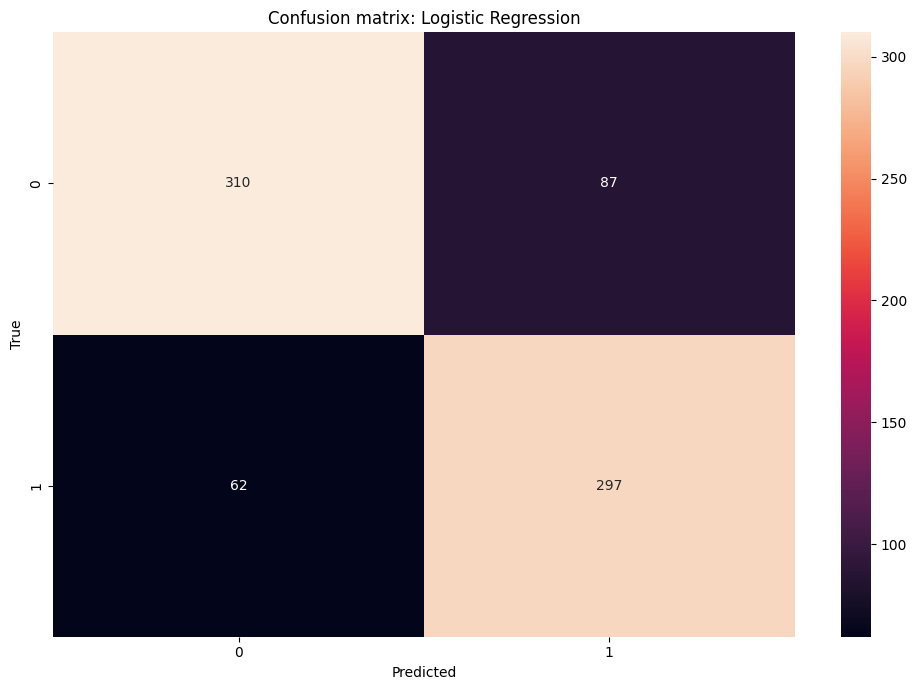

In [108]:
cm = metrics.confusion_matrix(Ytest, pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix: Logistic Regression')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [109]:
unique, counts = np.unique(pred, return_counts=True)
print(train['Transported'].value_counts())
print('\n',np.asarray((unique, counts)))

Transported
True     3804
False    3755
Name: count, dtype: int64

 [[  0   1]
 [372 384]]
